In [10]:
%load_ext autoreload
%autoreload 2

from src.data.medal import MeDALSubset
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import yaml
from src.models.trainer import ModelTrainer
from src.vectorizer.trainable import TrainableEmbedding
from src.vectorizer.glove_embeddings import GloVeEmbedding
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
from src.utils import save_embeddings_to_file
import pyarrow.parquet as pq
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
medal_dataset = MeDALSubset('MeDAL')
data, train_data, val_data, test_data = medal_dataset.load_dataset()
class_to_idx = medal_dataset.class_to_idx
del data, test_data

MeDAL dataset initialized with name: MeDAL
Dataset downloaded to: /Users/prashanthjaganathan/.cache/kagglehub/datasets/xhlulu/medal-emnlp/versions/4
Dataset moved to: /Users/prashanthjaganathan/Desktop/CS6120 - NLP/pretaining-language-models-for-medical-text/dataset
Total number of classes: 22555


In [2]:
%load_ext autoreload
%autoreload 2

def load_config(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

config = load_config('config/config.yaml')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
processed_train = medal_dataset.preprocess(['train', 'valid'])
# NOTE: Pre-processed for 503 minutes

In [ ]:
train_df, val_df = processed_train

# Save to CSV
# NOTE: commented out v sensitive code, files contain huge corpus of preprocessed data
# DO NOT OVERWRITE THE FILES
train_df.to_csv("dataset/medal/preprocessed_subset/train.csv", index=False)
val_df.to_csv("dataset/medal/preprocessed_subset/valid.csv", index=False)

print("CSV files saved successfully!")


CSV files saved successfully!


## Read and load pre-processed dataset

In [10]:
# preprocessed_train = pd.read_csv('dataset/medal/preprocessed_subset/train.csv')
preprocessed_val = pd.read_csv('dataset/medal/preprocessed_subset/valid.csv')
# medal_dataset.train_data = preprocessed_train
medal_dataset.val_data = preprocessed_val
print(len(medal_dataset.val_data))
del preprocessed_val


1000000


In [ ]:
train_abbr_tokens = medal_dataset.tokenize('nltk', splits=['train'])
df = pd.DataFrame(train_abbr_tokens, columns=['tokenized_text', 'abbreviation'])

# Save as a Parquet file
file_name = "dataset/medal/nltk_tokenized_subset/train.parquet"
df.to_parquet(file_name)
print('Parquet file saved successfully!')


In [ ]:
val_abbr_tokens = medal_dataset.tokenize('nltk', splits=['valid'])
df = pd.DataFrame(val_abbr_tokens, columns=['tokenized_text', 'abbreviation'])

# Save as a Parquet file
file_name = "dataset/medal/nltk_tokenized_subset/valid.parquet"
df.to_parquet(file_name)
print('Parquet file saved successfully!')


In [29]:
train_tokens = pd.read_parquet(
    "dataset/medal/nltk_tokenized_subset/train.parquet", 
    engine="pyarrow"
    ).squeeze()

# to make it as a list[list[str]]
tokenized_train_corpus = [(doc.tolist(), abbr) for doc, abbr in tqdm(zip(train_tokens['tokenized_text'], train_tokens['abbreviation']), 'Docs', len(train_tokens))] 
print(f'Number of documents in train corpus: {len(tokenized_train_corpus)}')
train_tokens = [doc for doc, _ in tokenized_train_corpus]
train_abbr = [abbv for _, abbv in tokenized_train_corpus]

Docs: 100%|██████████| 3000000/3000000 [00:15<00:00, 190767.96it/s]


Number of documents in train corpus: 3000000


In [ ]:
val_tokens = pd.read_parquet("dataset/medal/nltk_tokenized_subset/valid.parquet", engine="pyarrow").squeeze()

# to make it as a list[list[str]]
tokenized_val_corpus = [doc.tolist() for doc in tqdm(val_tokens, 'Docs', len(val_tokens))] 
print(f'Number of documents in val corpus: {len(tokenized_val_corpus)}')
val_tokens = [doc for doc, _ in tokenized_val_corpus]
val_abbr = [abbv for _, abbv in tokenized_val_corpus]

Docs: 100%|██████████| 1000000/1000000 [00:03<00:00, 264271.45it/s]


Number of documents in val corpus: 1000000


### Training Word2Vec model on the entire corpus

In [ ]:
embedding_model = TrainableEmbedding(
        tokenized_corpus=tokenized_train_corpus,
        algorithm="word2vec",
        vector_size=100,
        window=5,
        min_count=2
    )
embeddings = embedding_model.embed(tokenized_train_corpus)
print(f'Embedding dimensions: {len(embeddings[0][0])}')

### Training FastText model on the entire corpus

In [ ]:
embedding_model = TrainableEmbedding(
        tokenized_corpus=tokenized_train_corpus,
        algorithm="fasttext",
        vector_size=100,
        window=7,
        min_count=2
    )
embeddings = embedding_model.embed(tokenized_train_corpus)
print(f'Embeddings Dimensions: {len(embeddings[0][0])}')
save_embeddings_to_file(embeddings, "embeddings/fasttext_val_embeddings.h5")

Reducing the embedding to Truncated Singular Value Decomposition (SVD)

In [ ]:
embedding_model = TrainableEmbedding(
        tokenized_corpus=train_tokens.tolist(),
        algorithm="tfidf",
        vector_size=100,
        window=5,
        min_count=2
    )
embeddings = embedding_model.embed(train_tokens.tolist())
print(f'Embedding dimensions: {embeddings.shape}')

In [ ]:
# NOTE: bio wordvec model is like 12GB and unable to load it in the memeory and build embeddings

train_embeddings = medal_dataset.embed(
    'bio_wordvec',
    splits=['train'],
    tokenized_data = train_tokens,
    model_path = 'trained_models/embeddings/pretrained/bio_wordvec.bin'
)
len(train_embeddings)

Trying not to use bio bert as it involves trasformer models and our architecture is limited to using 
LSTM + Self Attention, therefore, looking for static embedding models only

In [ ]:
train_embeddings = medal_dataset.embed(
    'bio_bert', 
    splits=['train'],
    model_name='dmis-lab/biobert-base-cased-v1.1'
    )
len(train_embeddings)

In [8]:
tokenized_train_corpus = []

## Perform Model Training

First, let's create the dataloader with embeddings as features and labels.

In [ ]:
class LazyEmbeddingDataset(Dataset):
    def __init__(
            self, 
            file_path, 
            embedding_model, 
            labels, 
            class_to_idx, 
            return_tokens=True,
            max_seq_len=None):
        """
        Args:
            file_path (str): Path to the Parquet file containing the tokenized text.
            embedding_model: The custom embedding model (e.g., GloVeEmbedding).
            labels (list): Labels corresponding to each document.
            class_to_idx (dict): Mapping from class label to integer index.
            max_seq_len (int, optional): Max sequence length for padding/truncating.
        """
        self.file_path = file_path
        table = pq.read_table(self.file_path)
        self.tokenized_corpus = table['tokenized_text']  # Assuming the corpus is tokenized in the file
        self.corresponding_labels = table['abbreviation']
        self.embedding_model = embedding_model
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.max_seq_len = max_seq_len
        self.label_names = set(self.labels)
        self.return_tokens = return_tokens

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get the tokens for the current document
        tokens = self.tokenized_corpus[idx].as_py()  # Convert PyArrow StringScalar to string
        abbr = self.corresponding_labels[idx].as_py()

        if self.return_tokens:
            embeddings = self.embedding_model.token_indices(tokens, abbreviation=abbr)
        else:
            # Compute the embeddings for this document on the fly using the embedding model
            embeddings = self.embedding_model.embed(tokens)  # shape: (seq_len, embedding_dim)

        # Convert to numpy arrays
        embeddings = np.array(embeddings, dtype=np.float32)
        seq_len = len(embeddings)
        embedding_dim = self.embedding_model.embedding_dim


        # Padding/Truncation based on max_seq_len
        if self.max_seq_len is not None:
            if seq_len < self.max_seq_len:
                if self.return_tokens:
                    pad = np.zeros((self.max_seq_len - seq_len), dtype=np.float32)
                    embeddings = np.concatenate((embeddings, pad), axis=0)
                else:
                    pad = np.zeros((self.max_seq_len - seq_len, embedding_dim), dtype=np.float32)
                    embeddings = np.vstack([embeddings, pad])
            else:
                embeddings = embeddings[:self.max_seq_len]

        # Mask to indicate valid tokens
        mask = np.ones(seq_len, dtype=np.float32)
        if self.max_seq_len is not None and seq_len < self.max_seq_len:
            mask = np.concatenate([mask, np.zeros(self.max_seq_len - seq_len, dtype=np.float32)])

        # Convert label to index
        label = self.labels[idx]
        label_idx = self.class_to_idx[label]

        return (torch.tensor(embeddings, dtype=torch.float32),
                torch.tensor(mask, dtype=torch.float32),  # Return the mask
                torch.tensor(label_idx, dtype=torch.int64))


def create_lazy_dataloader(file_path, embedding_model, labels, class_to_idx, batch_size, max_seq_len=None):
    dataset = LazyEmbeddingDataset(file_path, embedding_model, labels, class_to_idx, max_seq_len=max_seq_len, return_tokens=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # return dataset

In [8]:
glove_embedding_model = GloVeEmbedding(**config['embedding_models']['glove'])

max_seq_len = config['datasets']['medal']['max_sequence_length']
batch_size = config['training']['hyperparameters']['batch_size']

trainloader = create_lazy_dataloader(
    'dataset/medal/nltk_tokenized_subset/train.parquet', 
    glove_embedding_model, 
    train_data['LABEL'],
    class_to_idx, 
    batch_size=batch_size,
    max_seq_len=max_seq_len
    )


valloader = create_lazy_dataloader(
    'dataset/medal/nltk_tokenized_subset/valid.parquet', 
    glove_embedding_model, 
    val_data['LABEL'],
    class_to_idx, 
    batch_size=batch_size,
    max_seq_len=max_seq_len
    )

In [9]:
# Use the new dataloaders
model_trainer = ModelTrainer()
train_results = model_trainer.train(
    trainloader, 
    valloader, 
    dataset='medal', 
    embedding_dim=100,
    embedding_model = glove_embedding_model
)

------- lstm_and_self_attention --------
{'lstm_units': 2, 'lstm_hidden_dim': 256, 'dropout': 0.3, 'num_classes': 22555, 'embedding_dim': 100, 'create_embedding_layer': True, 'embedding_model': <src.vectorizer.glove_embeddings.GloVeEmbedding object at 0x175ae0310>}


Training:   0%|          | 1/46875 [00:01<14:03:44,  1.08s/it]

Loss: 10.023731231689453


Training:  32%|███▏      | 15001/46875 [4:52:43<9:06:05,  1.03s/it] 

Loss: nan


Training:  64%|██████▍   | 29980/46875 [9:43:04<5:28:35,  1.17s/it] 


RuntimeError: stack expects each tensor to be equal size, but got [256] at entry 0 and [282] at entry 16

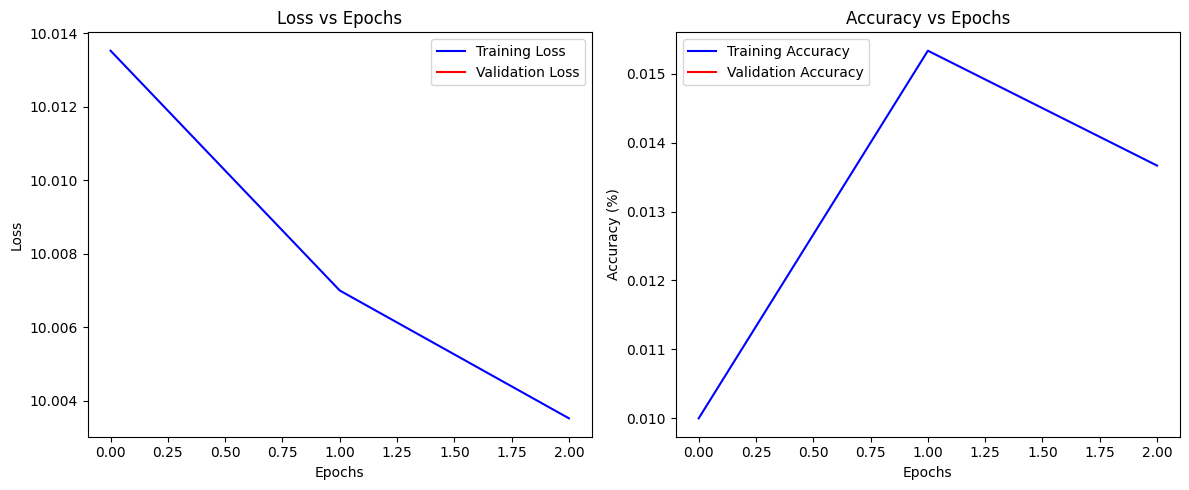

In [ ]:
model_trainer.plot_results(train_results)

# MIMIC III Dataset